<a href="https://colab.research.google.com/github/TomRaz/bv-play-break-detection/blob/main/bv_play_break_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# set the matplotlib backend so figures can be saved in the background
import matplotlib
from tqdm import tqdm

matplotlib.use("Agg")

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2

In [ ]:
# !rm -rf ./tagged2
# !unzip './drive/MyDrive/bv-detection-data/tagged.zip' -d ./tagged2

In [2]:

vids = list(paths.list_files("./tagged2",  (".mp4")))
print(len(vids))
epochs =50


924


100%|██████████| 231/231 [00:22<00:00, 10.28it/s]


[INFO] compiling model...
[INFO] training head...
Epoch 1/50
230/230 [==============================] - 96s 376ms/step - loss: 0.7030 - accuracy: 0.6035 - val_loss: 0.4871 - val_accuracy: 0.6680
Epoch 2/50
230/230 [==============================] - 86s 373ms/step - loss: 0.5846 - accuracy: 0.6379 - val_loss: 0.4622 - val_accuracy: 0.7309
Epoch 3/50
230/230 [==============================] - 86s 373ms/step - loss: 0.5468 - accuracy: 0.6639 - val_loss: 0.4606 - val_accuracy: 0.7359
Epoch 4/50
230/230 [==============================] - 86s 374ms/step - loss: 0.5477 - accuracy: 0.6451 - val_loss: 0.4647 - val_accuracy: 0.7258
Epoch 5/50
230/230 [==============================] - 86s 373ms/step - loss: 0.5375 - accuracy: 0.6612 - val_loss: 0.4714 - val_accuracy: 0.7063
Epoch 6/50
230/230 [==============================] - 86s 375ms/step - loss: 0.5325 - accuracy: 0.6678 - val_loss: 0.4833 - val_accuracy: 0.6684
Epoch 7/50
230/230 [==============================] - 86s 375ms/step - loss: 0.5

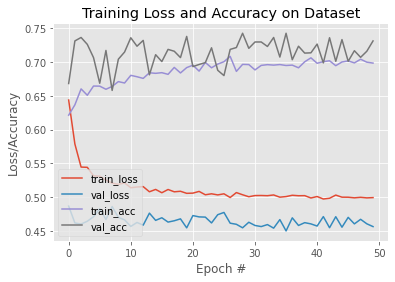

In [3]:
(vids_train, vids_test) = train_test_split(vids, test_size=0.25, random_state=42)


def get_from_vid(vid):
    data = []
    labels = []
    # extract the class label from the filename
    label = 0 if "break" in vid else 1

    # label = imagePath.split(os.path.sep)[-2]
    vs = cv2.VideoCapture(vid)
    count = 0
    while True:
        (grabbed, frame) = vs.read()
        if not grabbed:
            break

        # load the image, convert it to RGB channel ordering, and resize
        # it to be a fixed 224x224 pixels, ignoring aspect ratio
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        count += 45  # i.e. at 30 fps, this advances one second
        vs.set(1, count)
        # update the data and labels lists, respectively
        data.append(image)
        labels.append(label)
    return data, labels


trainX = []
trainY = []

testX = []
testY = []

for vid in tqdm(vids_train):
    d, l = get_from_vid(vid)
    trainX.extend(d)
    trainY.extend(l)

for vid in tqdm(vids_test):
    d, l = get_from_vid(vid)
    testX.extend(d)
    testY.extend(l)



# convert the data and labels to NumPy arrays
trainX = np.array(trainX)
trainY = np.array(trainY)

testX = np.array(testX)
testY = np.array(testY)

# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()

# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

# load the ResNet-50 network, ensuring the head FC layer sets are left
# off
baseModel = ResNet50(weights="imagenet", include_top=False,
                     input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in baseModel.layers:
    layer.trainable = False

# compile our model (this needs to be done after our setting our
# layers to being non-trainable)
print("[INFO] compiling model...")
opt = SGD(lr=1e-4, momentum=0.9, decay=1e-4 / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"])

# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("[INFO] training head...")
H = model.fit(
    x=trainAug.flow(trainX, trainY, batch_size=32),
    steps_per_epoch=len(trainX) // 32,
    validation_data=valAug.flow(testX, testY),
    validation_steps=len(testX) // 32,
    epochs=epochs)

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(x=testX.astype("float32"), batch_size=32)
# print(classification_report(testY.argmax(axis=0),
#                             predictions.argmax(axis=0), ))

# plot the training loss and accuracy
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")



# serialize the model to disk
print("[INFO] serializing network...")
model.save("/content/drive/MyDrive/bv-detection-data/activity.model", save_format="h5")